In [1]:
import sys; sys.path.insert(0, "../../")

import os
import logging
import random as rnd
from functools import partial
from typing import Callable

from jax import random, vmap
from flax.core import frozen_dict
from torchvision import transforms
import wandb
from flax.training.checkpoints import save_checkpoint, restore_checkpoint

from src.models import make_Cls_Ens_loss as make_ens_loss
from src.models.common import prune_labels
from src.data import get_image_dataset, NumpyLoader
from src.utils.training import setup_training, train_loop
from src.utils.notebook_metrics import *
from experiments.notebooks.utils.general import *

from operator import itemgetter
from  functools import partial
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import average_precision_score, roc_auc_score, \
                    precision_recall_curve, roc_curve, accuracy_score, precision_score, recall_score

from src.data.color_mnist import color_dict_str

# SELECT EXPERIMENT CONFIG (see experiments/configs/)
from experiments.configs.fmnist_cls_ens import get_config

import torch

2023-01-20 17:54:40.354588: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-20 17:54:41.137430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-20 17:54:41.137514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-20 17:54:41.137524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'fmnist_conditional_monotonicity.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find fmnist_conditional_monotonicity.ipynb.
wandb: Currently logged in as: metodj. Use `wandb login --relogin` to force relogin


True

In [4]:
config = get_config()

In [5]:
train_dataset, test_dataset, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)

train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)
test_loader = NumpyLoader(test_dataset, config.batch_size, num_workers=8)


X_test, y_test = list(zip(*test_loader.dataset))

In [6]:
RANDOM_SEED = 0

rng = random.PRNGKey(RANDOM_SEED)
setup_rng, rng = random.split(rng)
init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

model, state = setup_training(config, setup_rng, init_x, init_y)

+---------------------------------------------+------------+--------+-----------+--------+
| Name                                        | Shape      | Size   | Mean      | Std    |
+---------------------------------------------+------------+--------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |

In [7]:
_, state = train_loop(
    model, state, config, rng, make_ens_loss, make_ens_loss, train_loader, val_loader,
    # test_loader,
    wandb_kwargs={
        'mode': 'online',
        # 'notes': 'Data augmentation',
        # 'tags': ['MNIST testing'],
    },
    # plot_fn=make_plots,
    # plot_freq=1,
)

model_name = f"monotonicity/ens_model_{RANDOM_SEED}_{config.model.ll_type}"
save_checkpoint(model_name, state, 1, overwrite=True)

    

+---------------------------------------------+------------+--------+-----------+--------+
| Name                                        | Shape      | Size   | Mean      | Std    |
+---------------------------------------------+------------+--------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (100,)     | 100    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (100,)     | 100    | 1.0       | 0.0    |

2023-01-19 21:12:00.116052: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-19 21:12:00.693984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-19 21:12:00.694076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-19 21:12:00.694085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/50 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 0.97770, val loss: 0.63057, train err: 0.2848, val err: 0.2048, lr: 0.00360, prod_nll: 1.00000', ', members_nll: -0.97770')
Best val_err
epoch:   2 - ('train loss: 0.57396, val loss: 0.52850, train err: 0.1813, val err: 0.1713, lr: 0.00420, prod_nll: 1.00000', ', members_nll: -0.57396')
Best val_err
epoch:   3 - ('train loss: 0.50078, val loss: 0.48277, train err: 0.1617, val err: 0.1593, lr: 0.00480, prod_nll: 1.00000', ', members_nll: -0.50078')
Best val_err
epoch:   4 - ('train loss: 0.46056, val loss: 0.46835, train err: 0.1491, val err: 0.1540, lr: 0.00540, prod_nll: 1.00000', ', members_nll: -0.46056')
Best val_err
epoch:   5 - ('train loss: 0.43469, val loss: 0.43747, train err: 0.1414, val err: 0.1432, lr: 0.00600, prod_nll: 1.00000', ', members_nll: -0.43469')
Best val_err
epoch:   6 - ('train loss: 0.41186, val loss: 0.43678, train err: 0.1336, val err: 0.1382, lr: 0.00660, prod_nll: 1.00000', ', members_nll: -0.41186')
Best val_err
epoch:   7 - ('t

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▄▄▅▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train/err,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/members_nll,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train/nll_ratio,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train/prod_nll,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/err,█▆▅▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,44
best_val_err,0.10283


'monotonicity/ens_model_0_softmax/checkpoint_1'

In [8]:
df = metrics_df_by_name(["ens_model_0_softmax"], X_test, y_test, model, model, model_folder="monotonicity")

ens_model_0_softmax


In [11]:
df["err"]["mean"]

model_name           n_members
ens_model_0_softmax  1            0.11824
                     2            0.11269
                     3            0.11086
                     4            0.10942
                     5            0.10870
Name: mean, dtype: float64

In [7]:
MODEL_NAME = "ens_model_0_softmax"

state = restore_checkpoint(f'monotonicity/{MODEL_NAME}', 1)
    
pred_fun = partial(
        model.apply,
        {"params": state['params'], **state['model_state']},
        train=False,
        method=model.ens_logits
    )

In [8]:
logits = jax.vmap(
    pred_fun, axis_name="batch"
)(jnp.array(X_test))

In [14]:
np.save(f'monotonicity/logits/{MODEL_NAME}_logits.npy', np.transpose(np.array(logits), axes=(1, 0, 2)))
np.save(f'monotonicity/logits/{MODEL_NAME}_targets.npy',np.array(y_test))

In [98]:
def poe_classificiation_experts_predictive(logits: jnp.DeviceArray) -> jnp.DeviceArray:
    return jnp.nan_to_num((nn.sigmoid(logits).round().T / nn.sigmoid(logits).round().sum(axis=1)).T)

In [105]:
probs_softmax = np.array(nn.softmax(logits))
probs_ovr = np.array(jax.vmap(poe_classificiation_experts_predictive)(logits))
logits = np.array(logits)

In [100]:
# unit testing
assert logits.shape == probs_softmax.shape
assert np.isclose(probs_softmax[0, 0, :].sum(), 1.)

assert logits.shape == probs_ovr.shape
assert np.isclose(probs_ovr[0, 0, :].sum(), 1.)


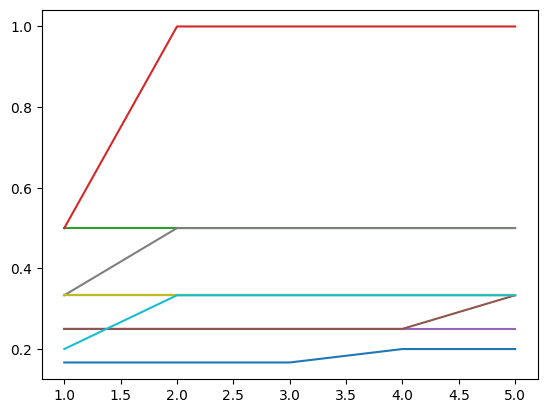

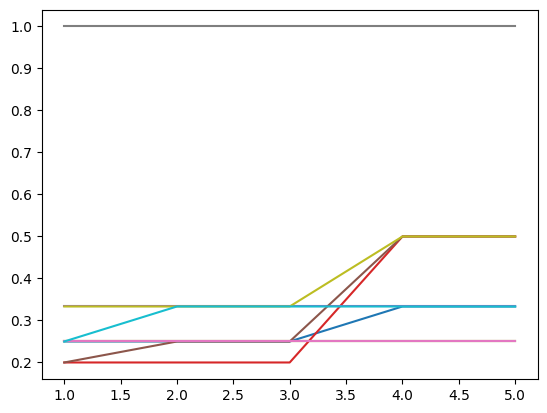

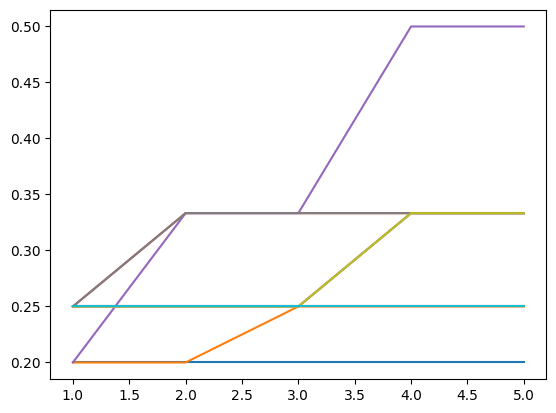

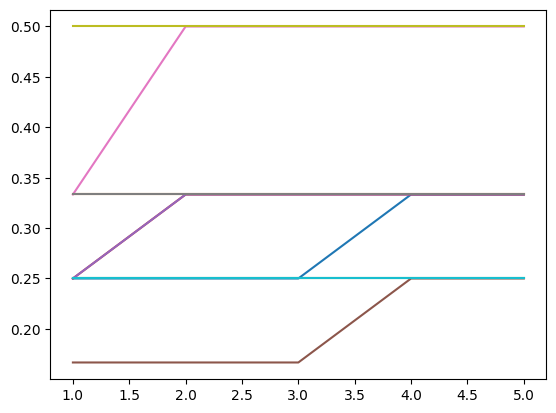

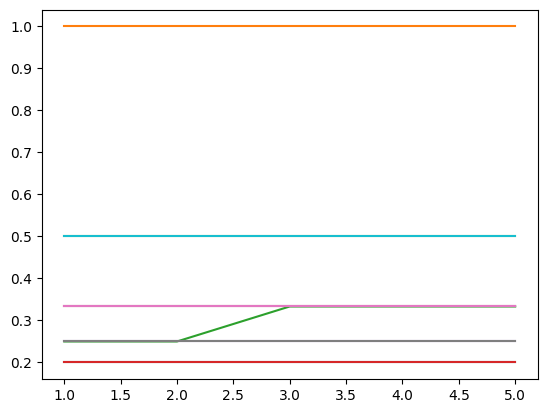

In [101]:
M = 5
C = 10

# TYPE = "de_softmax"
TYPE = "poe_ovr"

for _ in range(5):
    for i in rnd.sample(range(10000), 10):
        if TYPE == "de_softmax":
            probs_i = probs_softmax[i].cumsum(axis=0) / np.tile(np.arange(1, M + 1, 1), (C, 1)).T
        elif TYPE == "poe_ovr":
            probs_poe_ovr_i = probs_ovr[i].cumprod(axis=0)
            probs_i = probs_poe_ovr_i / np.tile(probs_poe_ovr_i.sum(axis=1), (C, 1)).T
        else:
            raise ValueError()
        modal_pred = probs_i[-1].argmax()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i[:, modal_pred])
    plt.show()

In [112]:
def ovr_likelihood(tensor: torch.Tensor) -> torch.tensor:
    tensor = torch.clone(tensor)
    # TODO: implement without for loops
    assert len(tensor.shape) == 3  # (L, N_test, C)
    for l in range(tensor.shape[0]):
        for n in range(tensor.shape[1]):
            ovr_mask = tensor[l, n, :] > 0
            nr_non_zero = ovr_mask.sum()
            if nr_non_zero == 0:
                nr_non_zero = 1  # to avoid division by 0
            tensor[l, n, :] = ovr_mask.long() / nr_non_zero
    return tensor
    

def f_probs_ovr_poe(tensor: torch.Tensor) -> torch.tensor:
    tensor = torch.clone(tensor)
    # TODO: implement without for loops
    assert len(tensor.shape) == 3  # (L, N_test, C)
    tensor = tensor.cumprod(dim=0)
    for l in range(tensor.shape[0]):
        for n in range(tensor.shape[1]):
            ovr_mask = tensor[l, n, :] > 0
            if ovr_mask.sum() > 0:
                tensor[l, n, :] = ovr_mask.long() / ovr_mask.sum()
    return tensor


def f_probs_ovr_poe_break_ties(logits, probs_ovr_poe, T=1.):
    logits, probs_ovr_poe = torch.clone(logits), torch.clone(probs_ovr_poe)
    # TODO: implement without for loops
    assert len(logits.shape) == 3  # (L, N_test, C)
    assert len(probs_ovr_poe.shape) == 3  # (L, N_test, C)
    preds = []
    for l in range(logits.shape[0]):
        preds_l = []
        for n in range(logits.shape[1]):
            ovr_mask = probs_ovr_poe[l, n, :] > 0
            preds_n = []
            sum_n = 0.
            for c in range(logits.shape[2]):
                if ovr_mask[c]:
                    sigmoid_prod = torch.sigmoid(T * logits[:l + 1, n, c]).prod()
                else:
                    sigmoid_prod = 0.
                sum_n += sigmoid_prod
                preds_n.append(sigmoid_prod)
            if sum_n > 0.:
                preds_n = [x / sum_n for x in preds_n]
            preds_l.append(preds_n)
        preds.append(preds_l)
    return torch.tensor(preds)

In [114]:

logits_T = torch.tensor(np.transpose(logits, axes=(1, 0, 2)))

In [120]:
targets = torch.tensor(y_test)

In [122]:
_probs_ovr = ovr_likelihood(logits_T)
_probs_poe_ovr = f_probs_ovr_poe(_probs_ovr)
_preds_poe_ovr = {i: torch.argmax(_probs_poe_ovr, dim=2)[i, :] for i in range(M)}
_acc_poe_ovr = [(targets == _preds_poe_ovr[i]).sum() / len(targets) for i in range(M)]

In [123]:
_acc_poe_ovr

[tensor(0.2232),
 tensor(0.2706),
 tensor(0.2960),
 tensor(0.3339),
 tensor(0.3460)]

In [126]:
_probs_poe_ovr_break_ties = f_probs_ovr_poe_break_ties(logits_T, _probs_poe_ovr)
_preds_poe_ovr_break_ties = {i: torch.argmax(_probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(M)}
acc_poe_ovr_break_ties = [1. - (targets == _preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(M)]

In [127]:
acc_poe_ovr_break_ties

[tensor(0.1191),
 tensor(0.1132),
 tensor(0.1127),
 tensor(0.1109),
 tensor(0.1106)]